# Notebook examples for Chapter 3

### Power spectrum of an image band

In [2]:
%matplotlib inline

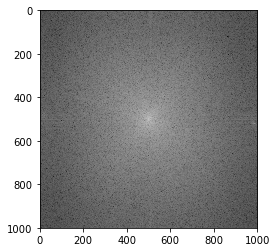

In [3]:
import numpy as np
from numpy import fft
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
import matplotlib.pyplot as plt

gdal.AllRegister()
infile = 'imagery/may0107'
                  
inDataset = gdal.Open(infile,GA_ReadOnly)     
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    

band = inDataset.GetRasterBand(3)  
image = band.ReadAsArray(0,0,cols,rows)
#  arrays of i and j values    
a = np.reshape(range(rows*cols),(rows,cols))
i = a % cols
j = a / cols
#  shift Fourier transform to center    
image1 = (-1)**(i+j)*image
#  compute power spectrum and display    
image1 = np.log(abs(fft.fft2(image1))**2)
mn = np.amin(image1)
mx = np.amax(image1)
plt.imshow((image1-mn)/(mx-mn), cmap='gray' )   

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter3/fig3_1.eps')

### Image compression with the Haar wavelet

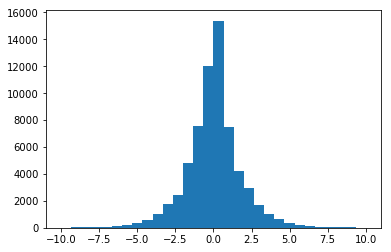

In [4]:
# The Haar mother wavelet
def psi_m(x):
    if x<0:return 0.0 
    elif x<=0.5:return 1.0
    elif x<=1.0:return -1.0
    else:return 0.0
# The Haar basis functions   
def psi(m,k,n):
    c = 2**n
    result = np.zeros(c)
    x = np.linspace(0,1,num=c)
    for i in range(c):
        result[i] = psi_m((2**m)*x[i]-k)
    return result

# Generate wavelet basis B_8
n = 8
B = np.ones((2**n,2**n))
i = 1
for m in range(n):
    for k in range(2**m):
        B[:,i] = psi(m,k,n)
        i += 1
B = np.mat(B)  

# 256x256 subset
G = np.mat(image[200:456,200:456])

# Wavelet transformation
Gw = np.mat(np.zeros((256,256)))
# Filter the columns
for j in range(256):
    Gw[:,j] = B.I*G[:,j]
# Filter the rows    
for i in range(256):
    Gw[i,:] = (B.I*Gw[i,:].T).T
# Histogram of wavelet coefficients    
Gw = np.array(Gw).ravel()
p = plt.hist(Gw,bins=30,range=(-10,10))

plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter3/fig3_6.eps')

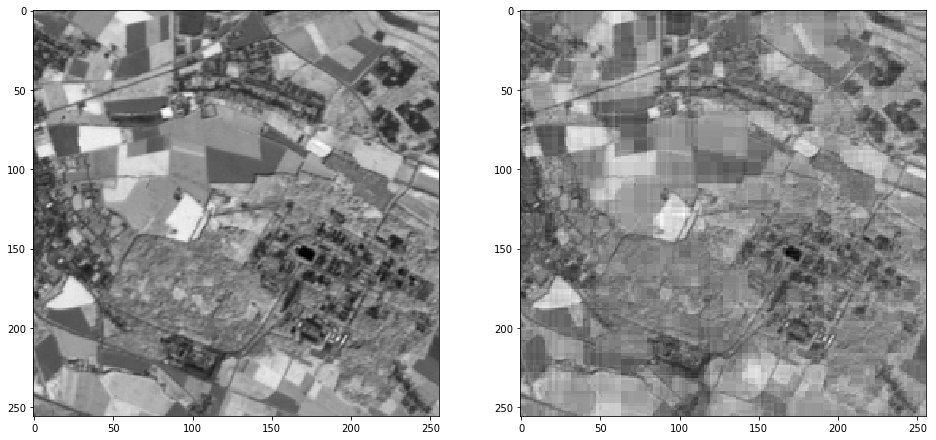

In [5]:
# Truncate and reshape
Gw = np.reshape(np.where(np.abs(Gw)<2,0,Gw),(256,256))
# Invert the transformation
Gw = np.mat(Gw)
Gc = np.mat(np.zeros((256,256)))
for i in range(256):
    Gc[i,:] = (B*Gw[i,:].T).T
for j in range(256):    
    Gc[:,j] = B*Gc[:,j]
f, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(np.array(G)/255,cmap='gray')
ax[1].imshow(np.array(Gc)/255,cmap='gray')

f.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter3/fig3_7.eps')

In [6]:
from scipy import sparse

sG = sparse.csr_matrix(G)
sGw = sparse.csr_matrix(Gw)
print sG.data.nbytes
print sGw.data.nbytes

262144
117088
